# Rootfinding

In this notebook I will do the speed comparisons.

We want to find the roots of the following real functions $f_i : \mathbb{R} \to \mathbb{R}$.

- $f_1(x) = f_1(x) = 0.5 x^{-0.5} + 0.5 x^{-0.2}$
- $f_2(x) = \log(a+x) - b$ for $(a, b) = 1.5, 1$
- $f_3(x) = - U'(a_0 + y_0 - x) + \beta (1+r) U'((1+r)\cdot x + y_1) $
for $U'(c) = c^{-\sigma}$ and $(a_0, y_0, y_1, r, \beta, \sigma) = (1, 1, 1, 0.03, 0.99, 2)$.

- $ f_4(x) = - U'(y_0 + a_0 - x) + \beta (1+r) \frac{1}{2} \bigl( U'(y_L + (1+r) x) + U'(y_H + (1+r) x))\bigr) $
where $U'(c) = c^{-\sigma}$, $(a_0, y_0, \bar y, r, \beta, \sigma) = (1, 1, 1, 0.03, 0.99, 2)$ and $\lambda \in \{ 0, 0.25, 0.5, 0.75 \}$.

These functions are found in `testfunctions.jl` and in the module `testfunctions.f90`.

We are using the methods 
1. bisection
2. newton
3. brent (Fortran Code by [Tony Smith](www.econ.yale.edu/smith/)).

The corresponding functions can be found in the files `rootfinding.jl` and `rootfinding.f90`.

## Description of the program
```
for i = 1:1000
    f_2 > bisect, newton, brent
    f_3 > bisect, brent
    f_4(λ) > bisect, brent λ = 0.25
end
```



In [2]:
include("Julia/testfunctions.jl")
include("Julia/rootfinding.jl")

zbrent (generic function with 1 method)

The `Julia` version of the test program is provided below.

In [3]:
function test(res2, res3, res4, toler, N, verbose)
    
    ## Julia's task is a bit harder, the starting values vary randomly
    xlow2 = (rand(N) .- 0.5)./100 .+ 0.001
    xhigh2 = (rand(N) .- 0.5)./100 .+ 5.0
    
    xlow3 = (rand(N) .- 0.5)./100 .+ 0.01
    xhigh3 = (rand(N) .- 0.5)./100 .+ 1.99
    
    for i = 1:N 
        x = 2.0
        iterations = 40
        toler = toler

        res2[1] = bisect(f2, xlow2[i], xhigh2[i], mxiter=iterations, toler=toler,verbose=verbose)
        res2[2] = newton(f2, f2p, xhigh2[i], mxiter=iterations, toler=toler, verbose=verbose)
        res2[3] = zbrent(f2, xlow2[i], xhigh2[i], rtol=toler, ftol=toler, itmax=iterations, verbose=verbose)
                
        res3[1] = bisect(f3, xlow3[i], xhigh3[i], mxiter=iterations, toler=toler, verbose=verbose)
        res3[2] = zbrent(f3, xlow3[i], xhigh3[i], rtol=toler, ftol=toler, itmax=iterations, verbose=verbose)
        


        res4[1] = bisect(x::Real -> f4(x, 0.25), xlow3[i], xhigh3[i], mxiter=iterations, toler=toler, verbose=verbose)
        res4[2] = zbrent(x::Real -> f4(x, 0.25), xlow3[i], xhigh3[i], rtol=toler, ftol=toler, itmax=iterations, verbose=verbose)
        
        if verbose
            mean2 = mean(res2)
            mean3 = mean(res3)
            mean4 = mean(res4)
            print("$mean2, $mean3, $mean4, $xlow2, $xhigh2\n")
        end
    end
end

res2 = zeros(3)
res3 = zeros(2)
res4 = zeros(2)

# warm up
test(res2, res3, res4, 1e-8, 100, false)
@show res2, res2, res4;

(res2,res2,res4) = ([1.21828,1.21828,1.21828],[1.21828,1.21828,1.21828],[0.529156,0.529156])


I want to call the compiled `Fortran` function from `Julia`. The `test()` function is in the `test_roots.f90` file. I compile it into a shared library `gfortran -shared test_roots.o rootfinding.o testfunctions.o constants.o -o lib_test_roots.dylib`. (The windows analogue would supposedly replace `*.dylib` by `*.so`).

I also code of `test_roots.f90` here for convenience.

```fortran
module test_roots
  
  use constants
  use functions
  use rootfinding

  implicit none
contains
  
  subroutine test(time, res2, res3, res4, verbose, toler, N)
    
  use constants
  use functions
  use rootfinding
    
  real(ndp) :: num, x = 2.0
  real(ndp) :: xlow2, xhigh2, xlow3, xhigh3, toler
  integer(i4b) :: i, iterations, N
  logical :: verbose ! = .false.
  integer :: time_start, time_end, rate
  real(ndp) :: time
            
  real(ndp) :: res2(3), res3(2), res4(2)


  call system_clock(COUNT_RATE=rate)
  call system_clock(COUNT=time_start)
  
  do i = 1,N
     xlow2 = 0.001
     xhigh2 = 5
     iterations = 60
     !toler = 1d-10

     res2(1) = bisect(f2, xlow2, xhigh2, iterations, toler, verbose)
     res2(2) = newton(f2, f2p, xhigh2, iterations, toler, verbose)
     res2(3) = zbrent(f2, xlow2, xhigh2, toler, toler, iterations, verbose)
     if (verbose) then
        write(6,"('f2: 'f15.8)") sum(res2)/3
     endif

     xlow3 = 0.1
     xhigh3 = 1.99
     res3(1) = bisect(f3, xlow3, xhigh3, iterations, toler, verbose)
     res3(2) = zbrent(f3, xlow3, xhigh3, toler, toler, iterations, verbose)
     if (verbose) then
        write(6,"('f3: 'f15.8)") sum(res3)/2
     endif

     res4(1) = bisect(f4, xlow3, xhigh3, iterations, toler, verbose)
     res4(2) = zbrent(f4, xlow3, xhigh3, toler, toler, iterations, verbose)
     if (verbose) then
        write(6,"('f4: 'f15.8)") sum(res4)/2
     endif
  enddo
  
  call system_clock(COUNT=time_end)
  time = time_end - time_start
  time = time/rate
end subroutine test
  
end module test_roots
```

Call the `makefile` to compile the code.

In [4]:
function test_f90(res2_f90, res3_f90, res4_f90, time_f90, toler_f90, N_f90, verbose_f90)
    ccall((:__test_roots_MOD_test, "Fortran90/lib_test_roots"), Void,
      (Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cint}, Ptr{Cdouble}, Ptr{Cint}),
      time_f90, res2_f90, res3_f90, res4_f90, verbose_f90, toler_f90, N_f90)
    time_f90.x
end

test_f90 (generic function with 1 method)

In [5]:
res2_f90 = zeros(3)
res3_f90 = zeros(2)
res4_f90 = zeros(2)
time_f90 = Ref{Cdouble}(0.)

toler = 1e-8
N = 100
verbose = false

toler_f90 = Ref{Cdouble}(toler)
N_f90 = Ref{Cint}(N)
verbose_f90 = Ref{Cint}(verbose)

test_f90(res2_f90, res3_f90, res4_f90, time_f90, toler_f90, N_f90, verbose_f90)
@show res2_f90;
@show res3_f90;
@show res4_f90;

res2_f90 = [1.21828,1.21828,1.21828]
res3_f90 = [0.532329,0.532329]
res4_f90 = [0.545132,0.545132]


In [6]:
M = 100
time_julia = zeros(M)
time_fortran = zeros(M)

for i = 1:M
    time_fortran[i] = test_f90(res2_f90, res3_f90, res4_f90, time_f90, toler_f90, N_f90, verbose_f90)
    time_julia[i] = @elapsed test(res2, res3, res4, toler, N, verbose)
end


In [7]:
@show res2, res2_f90;
@show res3, res3_f90;
@show res4, res4_f90;

(res2,res2_f90) = ([1.21828,1.21828,1.21828],[1.21828,1.21828,1.21828])
(res3,res3_f90) = ([0.499854,0.499854],[0.532329,0.532329])
(res4,res4_f90) = ([0.529156,0.529156],[0.545132,0.545132])


!!! It seems that the functions 3 and 4 are different for the two languages. That needs to be checked !!!

In [8]:
using Plots, PyPlot

[median(time_fortran);median(time_julia)] = [0.008,0.00169501]



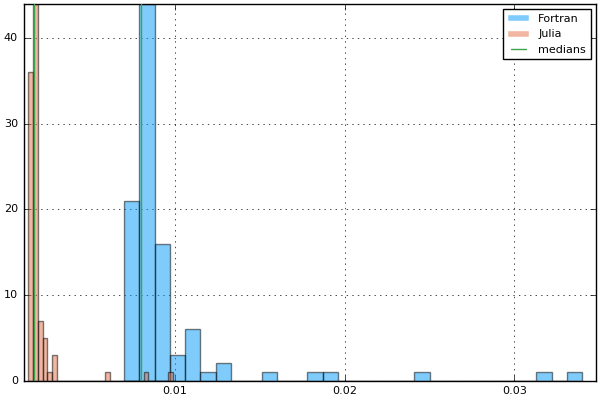

In [9]:
pyplot()

histogram(time_fortran[2:end], label="Fortran", alpha=0.5)
histogram!(time_julia[2:end], label="Julia", alpha=0.5)

@show [median(time_fortran);median(time_julia)]
plot!([median(time_fortran);median(time_julia)], linetype=:vline, label="medians")